<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import SimpleITK as sitk
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
plt.rcParams['figure.figsize'] = (10,8)
import pickle as pkl
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import torchvision.utils
from torchsummary import summary
import torch
import torch.nn as nn
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import time
import copy

%aimport mre 
from mre import pytorch_arch
%aimport mre.mre_datasets
from mre.mre_datasets import MRETorchDataset, MREtoXr, TorchToXr
%aimport mre.plotting
from mre.plotting import hv_dl_vis, hv_pred_comp, xr_viewer_v2
%aimport mre.train_mre_model
from mre.train_mre_model import train_model_full
%aimport mre.prediction
from mre.prediction import add_predictions, get_linear_fit

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')


# Load mre data
#xr_maker = MREtoXr(from_file='/pghbio/dbmi/batmanlab/Data/MRE/XR/*.nc')
#ds = xr_maker.get_ds()
#ds.persist()
#out_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data'


In [ ]:
#data_path = '/pghbio/dbmi/batmanlab/Data/MRE/XR_trimmed_with_contrast_gold/'
data_path = '/pghbio/dbmi/batmanlab/Data/MRE/XR_with_contrast_full_gold/'
data_file = '*.nc'
output_path = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data'
torch.cuda.empty_cache()
now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
print(now)

kwargs = dict(seed=33, num_epochs=100, in_channels=9, n_layers=5, channel_growth=True,
              model_cap=18, batch_size=8, num_workers=4,
              train_aug=True, gamma=0.6, lr_scheduler='step', lr_min=0.0001, lr_max=0.01, step_size=15, lr=5e-3,
              pixel_weight=1,
              subj=['0006', '0020', '0024', '0029', '0043', '0047', '0126', '0135'],
              train_smear='median',
              depth=True,
              dims=3, # 2D or 3D model arch
              # inputs=['t1_pre_water'],
              test_aug=False,
              test_smear='median',
              val_smear='median',
              do_val=True,
              dry_run=False)

inputs, targets, masks, names, model = train_model_full(data_path, data_file, output_path, model_version=f'notebook_test_{now}', **kwargs)


In [ ]:
ds_torch = TorchToXr(inputs, masks, targets, names).ds
xr_viewer_v2(ds_torch, size=350, prediction=False, torch=True)

In [2]:
# now = '2019-12-13_12-05-05'
#now = '2019-12-19_20-52-42' #(standard 2D training)
# now = '2019-12-19_22-12-26' #(overfit 2D training)
#now = '2019-12-21_22-34-20'
#now = '2019-12-31_17-47-33'
#now = '2020-01-02_18-31-17'
# now = '2020-01-06_10-37-35'
now = '2020-01-17_17-20-32'
xr_maker = MREtoXr(from_file=f'/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/XR/notebook_test_{now}/train/*.nc')
ds_train = xr_maker.get_ds()
ds_train = ds_train.load()
xr_maker = MREtoXr(from_file=f'/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/XR/notebook_test_{now}/test/*.nc')
ds_test = xr_maker.get_ds()
ds_test = ds_test.load()
xr_maker = MREtoXr(from_file=f'/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/XR/notebook_test_{now}/val/*.nc')
ds_val = xr_maker.get_ds()
ds_val = ds_val.load()

Called by IPython.
Within IPython QtConsole.
pylab loaded, but not in inline mode.
Called by IPython.
Within IPython QtConsole.
pylab loaded, but not in inline mode.
Called by IPython.
Within IPython QtConsole.
pylab loaded, but not in inline mode.


In [3]:
%%capture --no-display
xr_viewer_v2(ds_test, size=250, prediction=True)

Column
    [0] WidgetBox(css_classes=['widget-box'])
        [0] DiscreteSlider(formatter='%d', margin=(20, 20, 5, 20), name='z', options=OrderedDict([('0', ...]), value=0, width=250)
        [1] Select(margin=(0, 20, 5, 20), name='subject', options=['0006', '0020', ...], value='0006', width=250)
        [2] Select(margin=(5, 20, 20, 20), name='mask_type', options=['liver', 'mre', 'combo'], value='liver', width=250)
        [3] FloatSlider(end=1, name='mask transparency', start=0, value=0.7)
        [4] RangeSlider(end=2000, name='contrast', step=1, value=(0, 1000))
        [5] RangeSlider(end=12000, name='mre contrast', step=1, value=(0, 10000))
    [1] HoloViews(Layout)

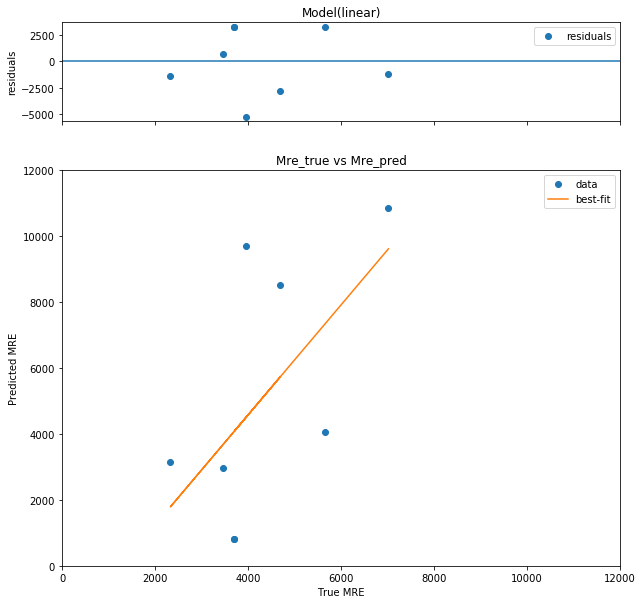

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 8
    # variables        = 2
    chi-square         = 71240888.3
    reduced chi-square = 11873481.4
    Akaike info crit   = 132.017088
    Bayesian info crit = 132.175971
[[Variables]]
    slope:      1.67027900 +/- 0.89656733 (53.68%) (init = 1.670279)
    intercept: -2101.67322 +/- 4056.54482 (193.02%) (init = -2101.673)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.954
R2: 0.36646450748010573


(1.6702790019100697, -2101.6732176350615)

In [5]:
get_linear_fit(ds_test, do_cor=True)